In [ ]:
import pandas as pd
from datetime import datetime
from transformers import pipeline
import requests
from bs4 import BeautifulSoup
from google.colab import auth
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from wordcloud import WordCloud
import matplotlib.pyplot as plt
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
import sys



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Web scraping CNBC for headlines
def scrape_cnbc_headlines():
    url = 'https://www.cnbc.com/search/?query=green%20hydrogen&qsearchterm=green%20hydrogen'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    headlines = [headline.text.strip() for headline in soup.find_all('a', class_='Card-title')]
    dates = [datetime.strptime(date.text.strip(), '%B %d, %Y') for date in soup.find_all('time')]
    sources = ['CNBC' for _ in range(len(headlines))]
    return headlines, dates, sources

In [ ]:
# Fetching headlines from Google News RSS feed
def fetch_google_news_headlines():
    url = 'https://news.google.com/rss/search?q=green%20hydrogen&hl=en-IN&gl=IN&ceid=IN:en'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    items = soup.find_all('item')
    headlines = [item.title.text for item in items]
    dates = [datetime.strptime(item.pubDate.text, '%a, %d %b %Y %H:%M:%S %Z') for item in items]
    sources = [item.source.text for item in items]
    return headlines, dates, sources

In [ ]:
# Sentiment analysis using Hugging Face pipeline
def get_sentiment_score(text):
    sentiment_analysis = pipeline('sentiment-analysis')
    result = sentiment_analysis(text)
    return result[0]['label'], result[0]['score']

In [ ]:
def get_organization_names(text):
    # Load the NER model
    ner_model = pipeline('ner')

    # Get entities from the text
    entities = ner_model(text)

    # Filter entities that are organization names
    organizations = []
    for entity in entities:
        if entity['entity'] == 'ORG':
            organizations.append(entity['word'])

    return organizations


In [ ]:
# Storing the data in a Pandas DataFrame
def create_dataframe():
    cnbc_headlines, cnbc_dates, cnbc_sources = scrape_cnbc_headlines()
    google_news_headlines, google_news_dates, google_news_sources = fetch_google_news_headlines()

    headlines = cnbc_headlines + google_news_headlines
    dates = cnbc_dates + google_news_dates
    sources = cnbc_sources + google_news_sources

    sentiments = []
    organizations = []

    for headline in headlines:
        sentiment, score = get_sentiment_score(headline)
        sentiments.append(score)
        orgs = get_organization_names(headline)
        organizations.append(', '.join(orgs))  # Concatenate organizations into a single string

    # Convert dates to string format
    dates = [date.strftime('%Y-%m-%d') for date in dates]

    df = pd.DataFrame({
        'Date': dates,
        'Headline': headlines,
        'Source': sources,
        'Sentiment Score': sentiments,
        'Organizations': organizations
    })

    return df



In [ ]:
# Save DataFrame to CSV
def save_to_csv(df):
    df.to_csv('green_hydrogen_news.csv', index=False)

In [ ]:
# Authenticate with Google Sheets API
def authenticate_google_sheets():
    auth.authenticate_user()
    return build('sheets', 'v4')


In [ ]:
# Upload data to Google Sheets
def upload_to_google_sheets(df, spreadsheet_id):
    service = authenticate_google_sheets()
    sheet = service.spreadsheets()
    result = sheet.values().append(
        spreadsheetId=spreadsheet_id,
        range="Sheet1!A1",
        valueInputOption="RAW",
        body={"values": df.values.tolist()}
    ).execute()
    print("Data successfully uploaded to Google Sheets!")

In [ ]:
# Generate Word Cloud
def generate_word_cloud(df):
    text = ' '.join(df['Headline'].str.cat(sep=' '))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
# Week wise trend of average sentiment score
def plot_sentiment_trend(df):
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime format
    df['Week'] = df['Date'].dt.strftime('%U-%Y')
    weekly_avg_sentiment = df.groupby('Week')['Sentiment Score'].mean()
    weekly_avg_sentiment.plot(kind='line', figsize=(10, 5))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

Data successfully uploaded to Google Sheets!


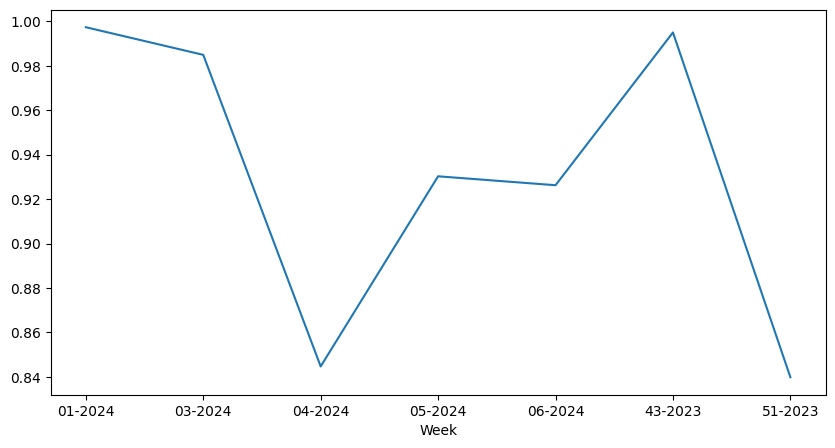

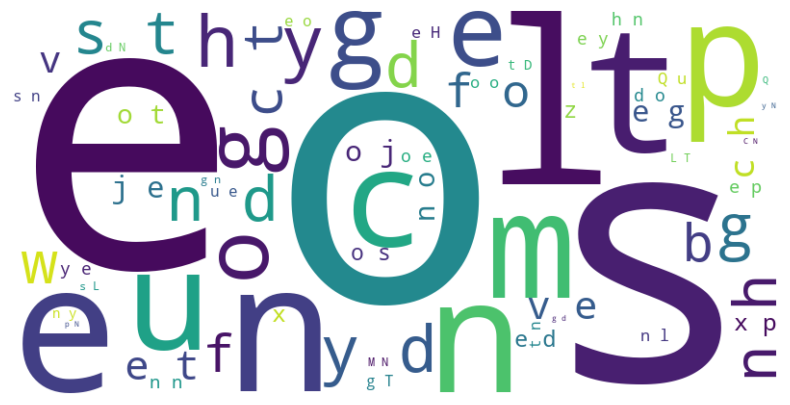

In [ ]:
# Main function
def main():
    df = create_dataframe()
    save_to_csv(df)

    # Transfer CSV to Google Sheets
    spreadsheet_id = '1mUHguml02S-iAlw03SwBLkKdwyevFkIH7_S1YSxYZEk'  # Replace with your Google Sheets ID
    upload_to_google_sheets(df, spreadsheet_id)

    # Plot sentiment trend
    plot_sentiment_trend(df)

    # Generate word cloud
    generate_word_cloud(df)

if __name__ == "__main__":
    main()